# 讀取MNIST資料

In [11]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.test.is_gpu_available()

True

In [47]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# 取出25張測試資料集圖片

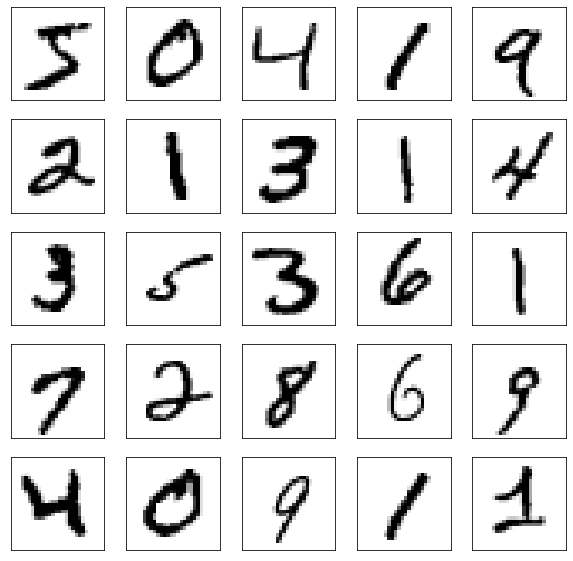

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap="binary")
plt.show()

# 資料預處理
* np.expand_dims將shape修改為(樣本數,圖片寬,圖片高,通道數)彩色為3，灰色為1
* Normalize圖片RGB由255降到0-1間

In [4]:
img_size = X_train.shape[1]
X_train = X_train / 255.
X_test = X_test / 255.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 建立模型

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Softmax
cnn = Sequential()
cnn.add(Conv2D(filters=1024, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)))
cnn.add(Conv2D(filters=512, kernel_size=(3,3), strides=2, activation='relu'))
#cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
cnn.add(Conv2D(filters=256, kernel_size=(3,3), strides=2, activation='relu'))
#cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
#cnn.add(Conv2D(filters=128, kernel_size=(1,1), activation='relu'))
cnn.add(Dense(units=128, activation='relu'))  #Param=6400*128+128=819328
cnn.add(Dense(units=10)) #Param=128*10+10=1290
cnn.add(Softmax())
#cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1024)      10240     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 512)       4719104   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         1179904   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

# 設定儲存最佳模型參數、提早停止模型訓練、儲存History

In [6]:
import os
model_dir = 'MNIST'
file_name = "MNIST-best-model"
modelfile = f"{model_dir}\\{file_name}.h5"
logfile = f"{model_dir}\\{file_name}_training.log"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
model_chpo = keras.callbacks.ModelCheckpoint(modelfile, monitor='val_accuracy', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
csv_logger = keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo, earlystop, csv_logger]

# 訓練模型

In [7]:
batch_size, epochs = 256, 100
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
    validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
235/235 [==============================] - 156s 665ms/step - loss: 0.4571 - accuracy: 0.8717 - val_loss: 0.0730 - val_accuracy: 0.9773
Epoch 2/100
235/235 [==============================] - 161s 684ms/step - loss: 0.0717 - accuracy: 0.9778 - val_loss: 0.0453 - val_accuracy: 0.9857
Epoch 3/100
235/235 [==============================] - 161s 685ms/step - loss: 0.0455 - accuracy: 0.9859 - val_loss: 0.0489 - val_accuracy: 0.9833
Epoch 4/100
235/235 [==============================] - 165s 703ms/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0382 - val_accuracy: 0.9867
Epoch 5/100
235/235 [==============================] - 173s 735ms/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0345 - val_accuracy: 0.9881
Epoch 6/100
 31/235 [==>...........................] - ETA: 2:24 - loss: 0.0241 - accuracy: 0.9938

KeyboardInterrupt: 

In [8]:
val, accuracy = cnn.evaluate(X_test, y_test)
print(f"損失Loss: {val:.4f}\n評估模型準確度: {accuracy:.4f}")

40/40 [==============================] - 7s 181ms/step - loss: 0.0304 - accuracy: 0.9891
損失Loss: 0.0304
評估模型準確度: 0.9891


In [10]:
pre = cnn.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

,0,1,2,3,4,5,6,7,8,9
0,971,1,1,0,0,1,5,1,0,0
1,0,1130,0,0,0,0,3,1,1,0
2,1,1,1018,1,0,0,2,5,4,0
3,0,0,0,1002,0,5,0,0,3,0
4,0,1,0,0,967,0,5,1,0,8
5,0,0,0,6,0,884,2,0,0,0
6,2,2,0,0,1,6,945,0,2,0
7,1,1,3,3,0,0,0,1020,0,0
8,2,0,2,2,1,0,1,1,962,3
9,1,3,0,1,3,6,0,2,1,992


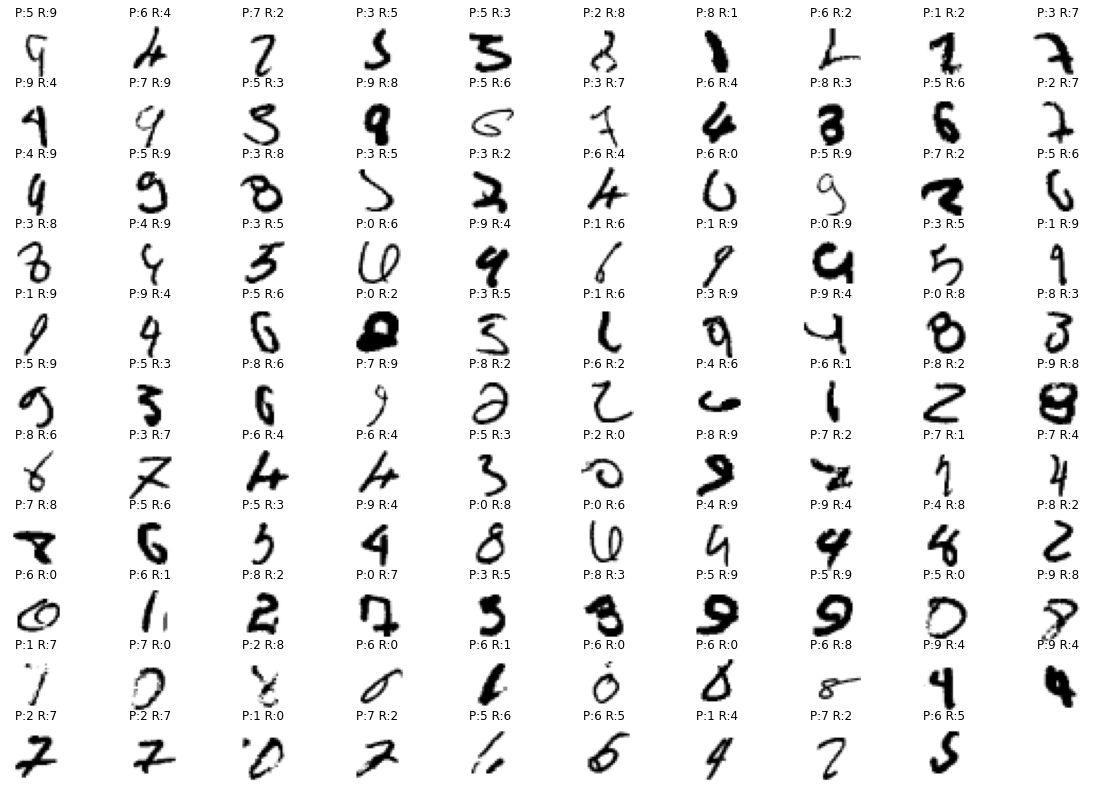

In [12]:
import numpy as np
wrong_list = np.nonzero(pre != y_test)[0] #預測錯誤列表
right_lable = y_test[wrong_list] #預測錯誤圖片的正確標籤
pre_lable = pre[wrong_list] #預測錯誤圖片的預測標籤
wrong_img = X_test[wrong_list] #錯誤圖片

plt.figure(figsize=(20,14))
width = 10
height = int(len(wrong_img)/10) + 1
for i, img in enumerate(wrong_img):
  plt.subplot(height, width, i+1)
  plt.axis("off")
  title = f"P:{pre_lable[i]} R:{right_lable[i]}"
  plt.title(title)
  plt.imshow(img, cmap="binary")

# 繪製Training圖表

MNIST\MNIST-best-model_training.log


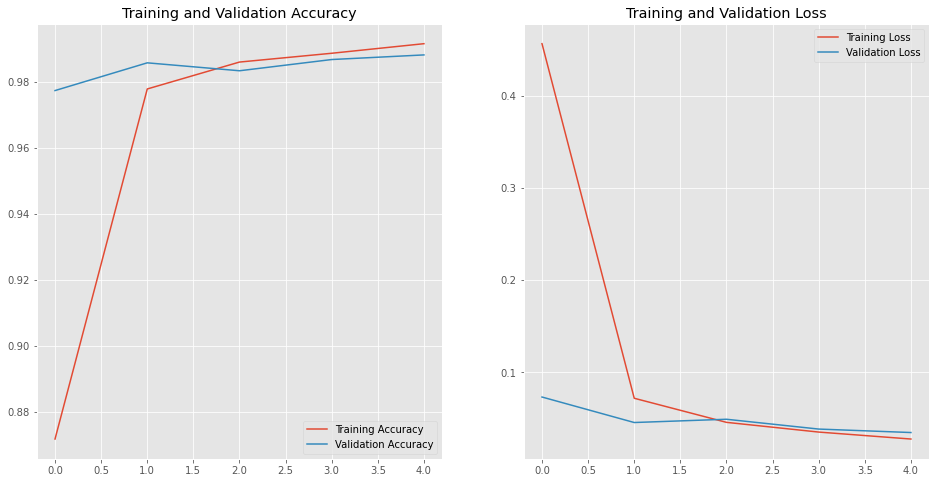

In [13]:
model_dir = 'MNIST'
file_name = "MNIST-best-model"
modelfile = f"{model_dir}\\{file_name}.h5"
logfile = f"{model_dir}\\{file_name}_training.log"
def plot_accuracy_loss(file_name):
    import pandas as pd
    log_data = pd.read_csv(file_name)
    acc = log_data['accuracy']
    val_acc = log_data['val_accuracy']
    loss = log_data['loss']
    val_loss = log_data['val_loss']
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], acc, label='Training Accuracy')
    plt.plot(log_data['epoch'], val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], loss, label='Training Loss')
    plt.plot(log_data['epoch'], val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()
print(logfile)
plot_accuracy_loss(logfile)

# 模型預測
* 不重新訓練模型預測，請先執行cell_1然後執行下方第一格。
* 執行上述過程後，即可直接使用下方第二格進行預測分析。

In [48]:
import tensorflow as tf
cnn = tf.keras.models.load_model(filepath=modelfile)

預測分類: 0


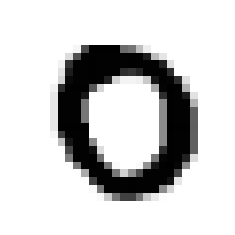

In [53]:
from random import randint
num_random = randint(0,X_train.shape[0]-1)
test_imp = np.expand_dims(X_train[num_random]/255., axis=0)
test_imp = np.expand_dims(test_imp,axis=-1)
pred = cnn.predict(test_imp)
print(f"預測分類: {range(0,10)[np.argmax(pred)]}")
plt.xticks([])
plt.yticks([])
plt.imshow(X_train[num_random], cmap="binary")